In [ ]:
!pip install sightengine
!pip install image-quality
# !pip install cpbd
# !pip install Pillow

     |████████████████████████████████| 153kB 2.7MB/s 
     |████████████████████████████████| 174kB 7.5MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp36-cp36m-linux_x86_64.whl size=233330 sha256=64177ed05e25f9cbada72771d9b9018deed9c76edf9dbcca928eeff0ad252786
  Stored in directory: /root/.cache/pip/wheels/5e/9e/b5/dbb033107407eec2f52b8cd24cf024a4b9ec8b62ea5aee995a
Successfully built libsvm


In [ ]:
from google.colab import drive
# import cpbd
from sightengine.client import SightengineClient
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
from time import time
import matplotlib.patheffects as path_effects

# Nothing important, just to make colors white
# to see them better, since the background is gray
params = {"ytick.color" : "c",
          "xtick.color" : "c",
          "axes.labelcolor" : "c",
          "axes.edgecolor" : "c",
          "text.color" : "c"}
plt.rcParams.update(params)
%matplotlib inline

from skimage.feature import canny
from math import atan2, pi

In [ ]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/data_')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def outline(color='black', *text):
    if text is None or len(text) == 0:
        return
    if len(text) > 1:
        for t in text:
            outline(color, t)
        return
    text[0].set_path_effects([path_effects.Stroke(linewidth=3, foreground=color),
                                path_effects.Normal()])

In [ ]:
from google.colab import files
def upload_files():
    uploaded = files.upload()
    for k, v in uploaded.items():
        open(k, 'wb').write(v)
    return list(uploaded.keys())

# Sharpness code 

In [ ]:
from scipy.ndimage import convolve
from skimage.filters.edges import HSOBEL_WEIGHTS


def sobel(image):
    # type: (numpy.ndarray) -> numpy.ndarray
    """
    Find edges using the Sobel approximation to the derivatives.
    Inspired by the [Octave implementation](https://sourceforge.net/p/octave/image/ci/default/tree/inst/edge.m#l196).
    """

    h1 = np.array(HSOBEL_WEIGHTS)
    h1 /= np.sum(abs(h1))  # normalize h1

    strength2 = np.square(convolve(image, h1.T))

    # Note: https://sourceforge.net/p/octave/image/ci/default/tree/inst/edge.m#l59
    thresh2 = 2 * np.sqrt(np.mean(strength2))

    strength2[strength2 <= thresh2] = 0
    return _simple_thinning(strength2)


def _simple_thinning(strength):
    # type: (numpy.ndarray) -> numpy.ndarray
    """
    Perform a very simple thinning.
    Inspired by the [Octave implementation](https://sourceforge.net/p/octave/image/ci/default/tree/inst/edge.m#l512).
    """
    num_rows, num_cols = strength.shape

    zero_column = np.zeros((num_rows, 1))
    zero_row = np.zeros((1, num_cols))

    x = (
        (strength > np.c_[zero_column, strength[:, :-1]]) &
        (strength > np.c_[strength[:, 1:], zero_column])
    )

    y = (
        (strength > np.r_[zero_row, strength[:-1, :]]) &
        (strength > np.r_[strength[1:, :], zero_row])
    )

    return x | y

In [ ]:
from skimage.feature import canny

# threshold to characterize blocks as edge/non-edge blocks
THRESHOLD = 0.002

# fitting parameter
BETA = 3.6

# block size
BLOCK_HEIGHT, BLOCK_WIDTH = (64, 64)

# just noticeable widths based on the perceptual experiments
WIDTH_JNB = np.concatenate([5*np.ones(51), 3*np.ones(205)])

def compute(image):
    # type: (numpy.ndarray) -> float
    """Compute the sharpness metric for the given data."""

    # convert the image to double for further processing
    image = image.astype(np.float64)

    # edge detection using canny and sobel canny edge detection is done to
    # classify the blocks as edge or non-edge blocks and sobel edge
    # detection is done for the purpose of edge width measurement.
    canny_edges = canny(image)
    sobel_edges = sobel(image)

    # edge width calculation
    marziliano_widths = marziliano_method(sobel_edges, image)

    # sharpness metric calculation
    return _calculate_sharpness_metric(image, canny_edges, marziliano_widths)


def marziliano_method(edges, image):
    # type: (numpy.ndarray, numpy.ndarray) -> numpy.ndarray
    """
    Calculate the widths of the given edges.
    :return: A matrix with the same dimensions as the given image with 0's at
        non-edge locations and edge-widths at the edge locations.
    """

    # `edge_widths` consists of zero and non-zero values. A zero value
    # indicates that there is no edge at that position and a non-zero value
    # indicates that there is an edge at that position and the value itself
    # gives the edge width.
    edge_widths = np.zeros(image.shape)

    # find the gradient for the image
    gradient_y, gradient_x = np.gradient(image)

    # dimensions of the image
    img_height, img_width = image.shape

    # holds the angle information of the edges
    edge_angles = np.zeros(image.shape)

    # calculate the angle of the edges
    for row in range(img_height):
        for col in range(img_width):
            if gradient_x[row, col] != 0:
                edge_angles[row, col] = atan2(gradient_y[row, col], gradient_x[row, col]) * (180 / pi)
            elif gradient_x[row, col] == 0 and gradient_y[row, col] == 0:
                edge_angles[row,col] = 0
            elif gradient_x[row, col] == 0 and gradient_y[row, col] == pi/2:
                edge_angles[row, col] = 90


    if np.any(edge_angles):

        # quantize the angle
        quantized_angles = 45 * np.round(edge_angles / 45)

        for row in range(1, img_height - 1):
            for col in range(1, img_width - 1):
                if edges[row, col] == 1:

                    # gradient angle = 180 or -180
                    if quantized_angles[row, col] == 180 or quantized_angles[row, col] == -180:
                        for margin in range(100 + 1):
                            inner_border = (col - 1) - margin
                            outer_border = (col - 2) - margin

                            # outside image or intensity increasing from left to right
                            if outer_border < 0 or (image[row, outer_border] - image[row, inner_border]) <= 0:
                                break

                        width_left = margin + 1

                        for margin in range(100 + 1):
                            inner_border = (col + 1) + margin
                            outer_border = (col + 2) + margin

                            # outside image or intensity increasing from left to right
                            if outer_border >= img_width or (image[row, outer_border] - image[row, inner_border]) >= 0:
                                break

                        width_right = margin + 1

                        edge_widths[row, col] = width_left + width_right


                    # gradient angle = 0
                    if quantized_angles[row, col] == 0:
                        for margin in range(100 + 1):
                            inner_border = (col - 1) - margin
                            outer_border = (col - 2) - margin

                            # outside image or intensity decreasing from left to right
                            if outer_border < 0 or (image[row, outer_border] - image[row, inner_border]) >= 0:
                                break

                        width_left = margin + 1

                        for margin in range(100 + 1):
                            inner_border = (col + 1) + margin
                            outer_border = (col + 2) + margin

                            # outside image or intensity decreasing from left to right
                            if outer_border >= img_width or (image[row, outer_border] - image[row, inner_border]) <= 0:
                                break

                        width_right = margin + 1

                        edge_widths[row, col] = width_right + width_left

    return edge_widths


def _calculate_sharpness_metric(image, edges, edge_widths):
    # type: (numpy.array, numpy.array, numpy.array) -> numpy.float64

    # get the size of image
    img_height, img_width = image.shape

    total_num_edges = 0
    hist_pblur = np.zeros(101)

    # maximum block indices
    num_blocks_vertically = int(img_height / BLOCK_HEIGHT)
    num_blocks_horizontally = int(img_width / BLOCK_WIDTH)

    #  loop over the blocks
    for i in range(num_blocks_vertically):
        for j in range(num_blocks_horizontally):

            # get the row and col indices for the block pixel positions
            rows = slice(BLOCK_HEIGHT * i, BLOCK_HEIGHT * (i + 1))
            cols = slice(BLOCK_WIDTH * j, BLOCK_WIDTH * (j + 1))

            if is_edge_block(edges[rows, cols], THRESHOLD):
                block_widths = edge_widths[rows, cols]
                # rotate block to simulate column-major boolean indexing
                block_widths = np.rot90(np.flipud(block_widths), 3)
                block_widths = block_widths[block_widths != 0]

                block_contrast = get_block_contrast(image[rows, cols])
                block_jnb = WIDTH_JNB[block_contrast]

                # calculate the probability of blur detection at the edges
                # detected in the block
                prob_blur_detection = 1 - np.exp(-abs(block_widths/block_jnb) ** BETA)

                # update the statistics using the block information
                for probability in prob_blur_detection:
                    bucket = int(round(probability * 100))
                    hist_pblur[bucket] += 1
                    total_num_edges += 1

    # normalize the pdf
    if total_num_edges > 0:
        hist_pblur = hist_pblur / total_num_edges

    # calculate the sharpness metric
    return np.sum(hist_pblur[:64])


def is_edge_block(block, threshold):
    # type: (numpy.ndarray, float) -> bool
    """Decide whether the given block is an edge block."""
    return np.count_nonzero(block) > (block.size * threshold)


def get_block_contrast(block):
    # type: (numpy.ndarray) -> int
    return int(np.max(block) - np.min(block))

# Read all train images

In [ ]:
allstart = time()
main_folder = 'train'

X, paths = [], []
class_names = {}
num_rooms = len(os.listdir(main_folder))
for i, room in enumerate(os.listdir(main_folder)):
    print(f'Read {room}s', end=' ')
    start = time()
    room_path = os.path.join(main_folder, room)
    num_images = 0
    for filename in os.listdir(room_path):
        image = cv2.imread(os.path.join(room_path, filename))

        X.append(image)
        paths.append(f'/content/drive/My Drive/data_/{os.path.join(room_path, filename)}')
        class_names[i] = room

        num_images += 1

    print(f'in {time() - start:.2f} seconds. There are {num_images} images of {room}s.')

print()
print(f'### All read in {time() - allstart} seconds.')

Read Rooms in 4.65 seconds. There are 324 images of Rooms.
Read Outs in 5.13 seconds. There are 324 images of Outs.
Read Gardens in 2.06 seconds. There are 126 images of Gardens.
Read Bathrooms in 4.01 seconds. There are 324 images of Bathrooms.
Read Livingrooms in 5.09 seconds. There are 324 images of Livingrooms.
Read Kitchens in 8.28 seconds. There are 324 images of Kitchens.
Read Bedrooms in 2.32 seconds. There are 162 images of Bedrooms.
Read Lines in 0.83 seconds. There are 75 images of Lines.

### All read in 32.774911880493164 seconds.


# My Functions

### Brightness Function

In [ ]:
def my_brightness(image):
    return np.mean(cv2.cvtColor(image, cv2.COLOR_BGR2YUV)[:,:,0]) / 255.0

### Contrast Function

In [ ]:
# def my_contrast(image):
#     Y = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)[:,:,0]
#     m = np.min(Y).astype(np.int16)
#     M = np.max(Y).astype(np.int16)
#     C = (M - m) / (M + m)
#     return (C + 1) / 2

# def my_contrast(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     C = gray.std()
#     return C

def my_contrast(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    assert len(image.shape) == 2, "'image' needs to be a grayscale image"
    # 9 different resolution levels
    GCF = 0
    resolutions = [1, 2, 4, 8, 16, 25, 50, 100, 200]    
    LC = np.zeros(len(resolutions))
    for i, res in enumerate(resolutions):
        
        W = image.shape[1] // res
        H = image.shape[0] // res
        
        # attempt at resizing as in the paper
        rImage = cv2.resize(image, (W, H))
        # compute linear luminance l
        l = (rImage.astype(np.float) / 255) * 2.2
        # compute perceptual luminance L
        rL = 100 * np.sqrt(l)
        
        # compute local contrast for each pixel
        lc = 0
        for x in range(H):
            for y in range(W):
                if x == 0:
                    if y == 0: 
                        lc += (np.abs(rL[x, y] - rL[x, y+1]) + np.abs(rL[x, y] - rL[x+1, y])) / 2
                    elif y == W - 1:
                        lc += (np.abs(rL[x, y] - rL[x, y-1]) + np.abs(rL[x, y] - rL[x+1, y])) / 2
                    else:
                        lc += (np.abs(rL[x, y] - rL[x, y-1]) + np.abs(rL[x, y] - rL[x, y+1]) + np.abs(rL[x, y] - rL[x+1, y])) / 3
                    
                elif x == H - 1:
                    if y == 0:
                        lc += (np.abs(rL[x, y] - rL[x, y+1]) + np.abs(rL[x, y] - rL[x-1, y])) / 2
                    elif y == W - 1:
                        lc += (np.abs(rL[x, y] - rL[x, y-1]) + np.abs(rL[x, y] - rL[x-1, y])) / 2
                    else: 
                        lc += (np.abs(rL[x, y] - rL[x, y-1]) + np.abs(rL[x, y] - rL[x, y+1]) + np.abs(rL[x, y] - rL[x-1, y])) / 3
                    
                else:
                    if y == 0:
                        lc += (np.abs(rL[x, y] - rL[x, y+1]) + np.abs(rL[x, y] - rL[x+1, y]) + np.abs(rL[x, y] - rL[x-1, y])) / 3
                    elif y == W - 1:
                        lc += (np.abs(rL[x, y] - rL[x, y-1]) + np.abs(rL[x, y] - rL[x+1, y]) + np.abs(rL[x, y] - rL[x-1, y])) / 3
                    else:
                        lc += (np.abs(rL[x, y] - rL[x, y-1]) + np.abs(rL[x, y] - rL[x, y+1]) + np.abs(rL[x, y] - rL[x-1, y]) + np.abs(rL[x, y] - rL[x+1, y])) / 4
        
        # compute average local contrast c
        ci = lc / (W * H)
        wi = (-0.406385 * (i / 9) + 0.334573) * (i / 9) + 0.0877526
        
        # compute global contrast factor
        LC[i] = ci * wi
        GCF = GCF + LC[i]
        
    return GCF #, LC

### Sharpness Function

In [ ]:
# def my_sharpness(image):
#     return compute(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

def my_sharpness(image):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5) # 5x5
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5) # 5x5
    G = np.sqrt((sobelx ** 2 + sobely ** 2))
    S = G.mean()

    # Mapping
    C1 = [0.01973334, 5.00009004]
    C2 = [0.00250833, 0.77154772]
    S = np.log(S)
    S = S - C1[1]
    S = (S / C1[0]) * C2[0]
    S = S + C2[1]

    return min(S, 1.0)

# Comparing Function

In [ ]:
def compare(i, show=True):
    path = paths[i]

    client = SightengineClient('54728470', 'HWFs4bVA7cvcdqL9sW7x')
    output = client.check('properties').set_file(path)
    
    use_google = True
    if output['status'] == 'failure':
        # print(output['error']['message'])
        use_google = False
    #     return False, False, False, False, False, False

    if use_google:
        g_brightness = output['brightness']
        g_contrast = output['contrast']
        g_sharpness = output['sharpness']
    else:
        g_brightness = -1
        g_contrast = -1
        g_sharpness = -1

    image = cv2.imread(path)

    mbt = r"$\bf{Mine:}$ %.3f" % my_brightness(image)
    gbt = r"$\bf{Google's:}$ %.3f" % g_brightness

    mct = r"$\bf{Mine:}$ %.3f" % my_contrast(image)
    gct = r"$\bf{Google's:}$ %.3f" % g_contrast
    
    mst = r"$\bf{Mine:}$ %.3f" % my_sharpness(image)
    gst = r"$\bf{Google's:}$ %.3f" % g_sharpness

    if show:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

        ax1.imshow(image[:,:,::-1])
        ax2.imshow(np.ones((50, 100)) * 35, cmap='gray', vmin=0, vmax=255)
        # Brightness Title
        outline('black',
                ax2.text(15, 17, 'Brightness', color='r', fontweight='bold',
                        fontsize=14, horizontalalignment='center',
                        verticalalignment='center'))
        # Brightness Values
        ax2.text(15, 25, f'{gbt}\n{mbt}', color='w', fontsize=12,
                horizontalalignment='center', verticalalignment='center')
        # Sharpness Title
        outline('black',
                ax2.text(50, 17, 'Sharpness', color='r', fontweight='bold',
                        fontsize=14, horizontalalignment='center',
                        verticalalignment='center'))
        # Sharpness Values
        ax2.text(50, 25, f'{gst}\n{mst}', color='w', fontsize=12,
                horizontalalignment='center', verticalalignment='center')
        # Contrast Title
        outline('black',
                ax2.text(85, 17, 'Contrast', color='r', fontweight='bold',
                        fontsize=14, horizontalalignment='center',
                        verticalalignment='center'))
        # Contrast Values
        ax2.text(85, 25, f'{gct}\n{mct}', color='w', fontsize=12,
                horizontalalignment='center', verticalalignment='center')
        ax2.set_xticks([], [])
        ax2.set_yticks([], [])
        plt.show()
    
    return my_brightness(image), g_brightness, my_contrast(image), g_contrast, my_sharpness(image), g_sharpness

## Randomly comparing 100 images

Getting values for image 001/100.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


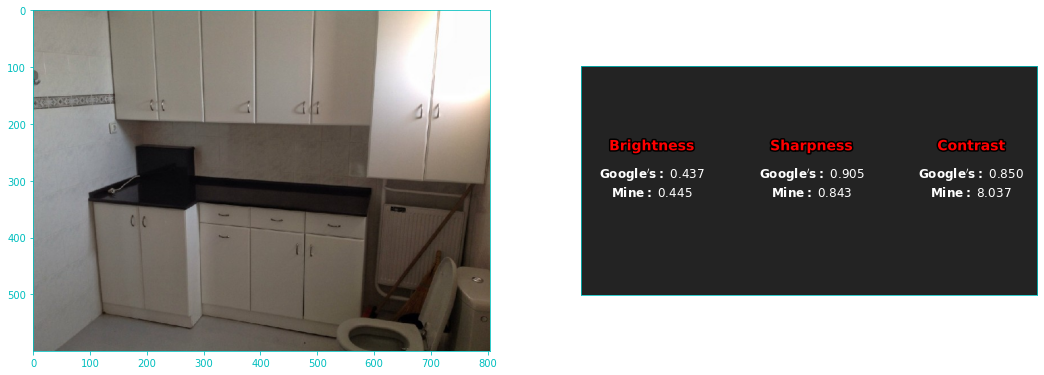

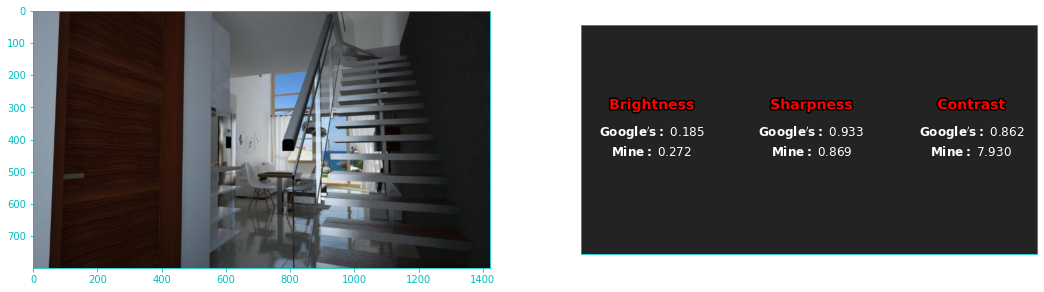

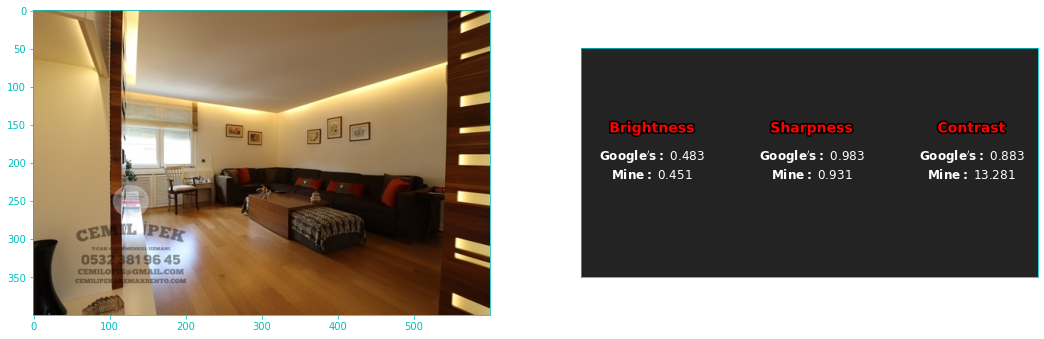

Getting values for image 011/100.


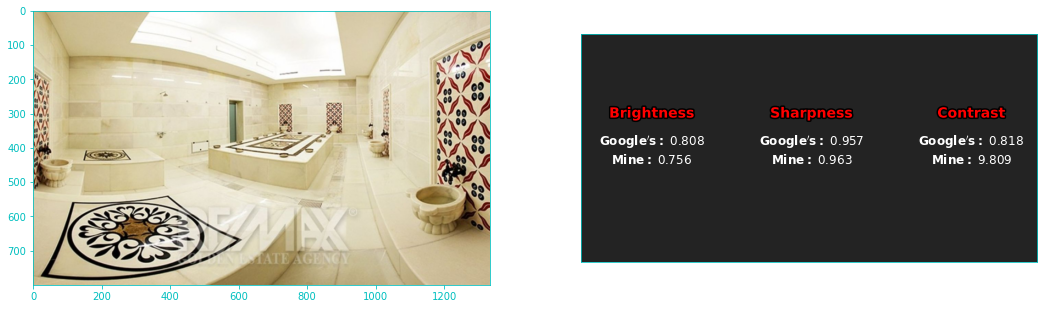

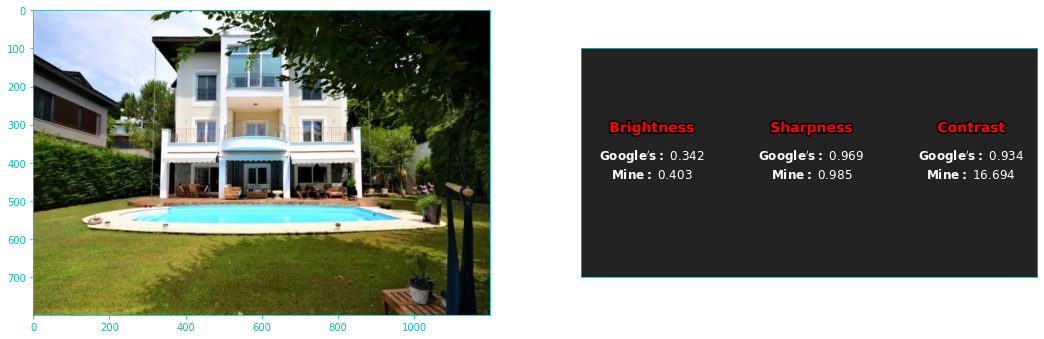

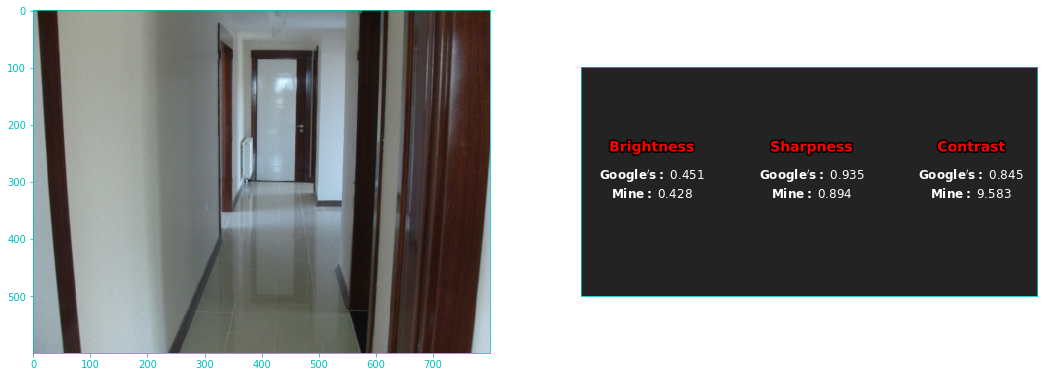

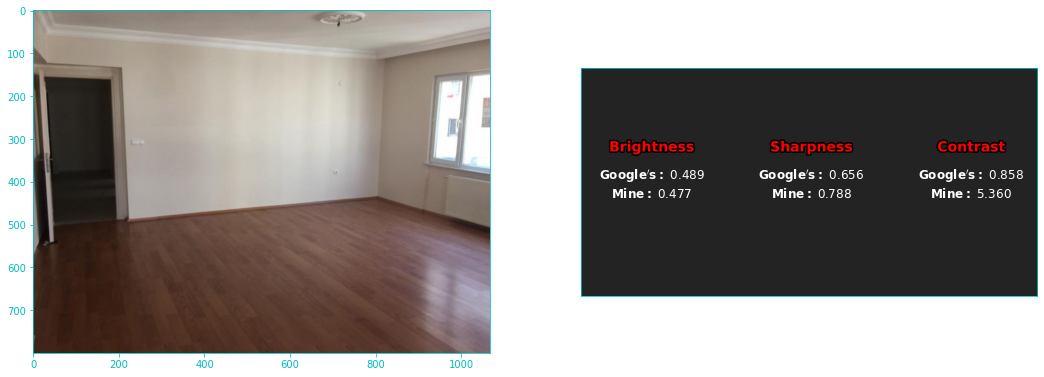

Getting values for image 021/100.


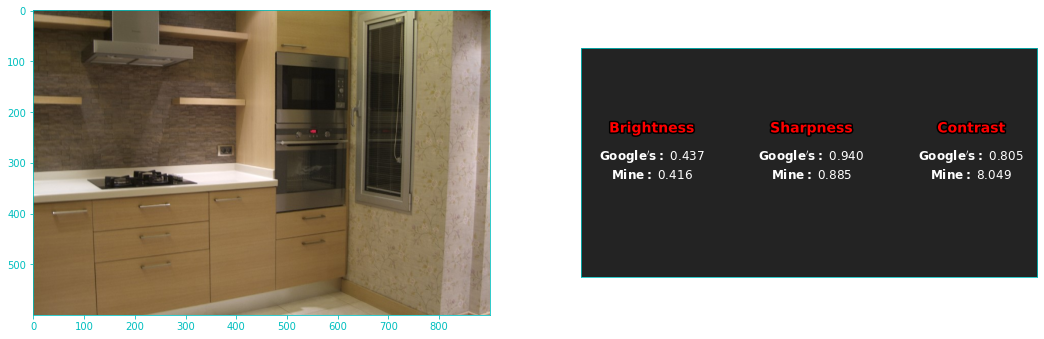

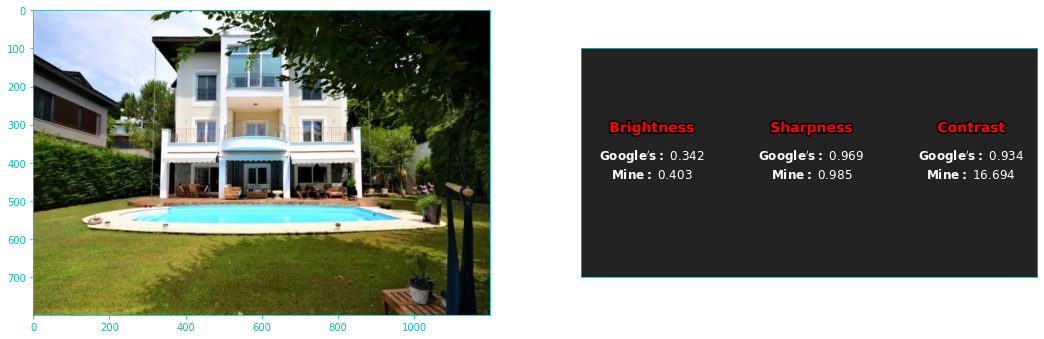

In [ ]:
size = 100
num_print = 10
random_indices = np.random.randint(len(X), size=100)
brightness_values = []
contrast_values = []
sharpness_values = []
for i, index in enumerate(random_indices):
    if i % (size // num_print) == 0:
        print(f'Getting values for image {i+1:03d}/{size}.')
    # print(f'Image {i+1:03d}/{size}')
    mb, gb, mc, gc, ms, gs = compare(index, show < 20)
    if mb is False:
        break
    brightness_values.append((mb, gb))
    contrast_values.append((mc, gc))
    sharpness_values.append((ms, gs))
brightness_values = np.array(brightness_values)
brightness_values = brightness_values[brightness_values[:, 0].argsort()]
contrast_values = np.array(contrast_values)
contrast_values = contrast_values[contrast_values[:, 0].argsort()]
sharpness_values = np.array(sharpness_values)
sharpness_values = sharpness_values[sharpness_values[:, 0].argsort()]

### Comparing brightness values for random 100 images

In [ ]:
x = np.arange(brightness_values.shape[0])
plt.figure(figsize=(14, 7))
plt.scatter(x, brightness_values[:, 0], label='My Brightness Values', alpha=0.7)
plt.scatter(x, brightness_values[:, 1], label='Google\'s Brightness Values', alpha=0.7)
plt.ylim(0, 1)
plt.xlabel('Image index', color='c', fontsize=14, fontweight='bold')
plt.ylabel('Brightness', color='c', fontsize=14, fontweight='bold')
l = plt.legend()
for text in l.get_texts():
    text.set_color('k')
plt.show()

### Comparing contrast values for random 100 images

In [ ]:
x = np.arange(contrast_values.shape[0])
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(14, 10))
ax1.scatter(x, contrast_values[:, 0], label='My Contrast Values', alpha=0.7)
ax2.scatter(x, contrast_values[:, 1], label='Google\'s Contrast Values', alpha=0.7, color='C1')
ax1.set_xlabel('Image index', color='c', fontsize=14, fontweight='bold')
ax2.set_xlabel('Image index', color='c', fontsize=14, fontweight='bold')
ax1.set_ylabel('Contrast', color='c', fontsize=14, fontweight='bold')
ax2.set_ylabel('Contrast', color='c', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1)
l = ax1.legend()
for text in l.get_texts():
    text.set_color('k')
l = ax2.legend()
for text in l.get_texts():
    text.set_color('k')
plt.show()

### Comparing sharpness values for random 100 images

In [ ]:
x = np.arange(sharpness_values.shape[0])
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(14, 10))
ax1.scatter(x, sharpness_values[:, 0], label='My Sharpness Values', alpha=0.7)
ax2.scatter(x, sharpness_values[:, 1], label='Google\'s Sharpness Values', alpha=0.7, color='C1')
ax1.set_xlabel('Image index', color='c', fontsize=14, fontweight='bold')
ax2.set_xlabel('Image index', color='c', fontsize=14, fontweight='bold')
ax1.set_ylabel('Sharpness', color='c', fontsize=14, fontweight='bold')
ax2.set_ylabel('Sharpness', color='c', fontsize=14, fontweight='bold')

Z1 = np.polyfit(x, sharpness_values[:, 0], 1)
Z2 = np.polyfit(x, sharpness_values[:, 1], 1)
print('Z1:', Z1)
print('Z2:', Z2)

ax1.plot(x, np.c_[x, np.ones(sharpness_values.shape[0])].dot(Z1), label='Linear Fit', color='C2')
ax2.plot(x, np.c_[x, np.ones(sharpness_values.shape[0])].dot(Z2), label='Linear Fit', color='C2')

ax2.set_ylim(0, 1)
ax1.set_ylim(0, 1)
l = ax1.legend()
for text in l.get_texts():
    text.set_color('k')
l = ax2.legend()
for text in l.get_texts():
    text.set_color('k')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.set_title('Both at the same plot', color='c')
ax.scatter(x, sharpness_values[:, 0], label='My Sharpness Values', alpha=0.7)
ax.scatter(x, sharpness_values[:, 1], label='Google\'s Sharpness Values', alpha=0.7, color='C1')
ax.set_xlabel('Image index', color='c', fontsize=14, fontweight='bold')
ax1.set_ylabel('Sharpness', color='c', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
l = ax.legend()
for text in l.get_texts():
    text.set_color('k')
plt.show()

# Testing our sharpness function with some artificially blurred images

### Getting blurred and original images

In [ ]:
size = 30
indices = np.random.choice(len(X), size=size)
blurred = []
original = []
for index in indices:
    image = X[index]
    original.append(image)
    blurred.append(cv2.GaussianBlur(image, (11, 11), 0))

In [ ]:
fig, axs = plt.subplots(size+1, 2, figsize=(20, 180))
axs[0, 0].imshow(np.ones((20, 50)) * 35, cmap='gray', vmin=0, vmax=255)
axs[0, 1].imshow(np.ones((20, 50)) * 35, cmap='gray', vmin=0, vmax=255)
axs[0, 0].set_xticks([], [])
axs[0, 0].set_yticks([], [])
axs[0, 1].set_xticks([], [])
axs[0, 1].set_yticks([], [])
outline('black',
        axs[0, 0].text(25, 9, 'Blurred', color='r', fontweight='bold',
                       fontsize=34, horizontalalignment='center',
                       verticalalignment='center'),
        axs[0, 1].text(25, 9, 'Original', color='r', fontweight='bold',
                       fontsize=34, horizontalalignment='center',
                       verticalalignment='center'))
for i in range(size):
    [axleft, axright] = axs[i+1, :]
    blurred_image = blurred[i][:, :, ::-1]
    original_image = original[i][:, :, ::-1]
    axleft.set_title(f'Our sharpess value: {my_sharpness(blurred_image):.2f}', color='c')
    axleft.imshow(blurred_image)
    axright.set_title(f'Our sharpess value: {my_sharpness(original_image):.2f}', color='c')
    axright.imshow(original_image)
    axleft.set_xticks([], [])
    axleft.set_yticks([], [])
    axright.set_xticks([], [])
    axright.set_yticks([], [])
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 7))
plt.title('Sharpness values of Blurred and Original images using our sharpness function', color='c', fontsize=24)
plt.plot(list(map(my_sharpness, blurred)), label='Blurred')
plt.plot(list(map(my_sharpness, original)), label='Original')
plt.ylabel('Our sharpness value', color='c', fontsize=24)
plt.xlabel('Image index', color='c', fontsize=24)
l = plt.legend()
for text in l.get_texts():
    text.set_color('k')
plt.show()

# Brisque python kodu deneme

In [ ]:
import imquality.brisque as brisque

size = 30
indices = np.random.choice(len(X), size=size)
for index in indices:
    image = X[index]
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.set_title(f'Brisque Score: {brisque.score(image)}', fontsize=20, color='c')
    ax.imshow(image)
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    plt.show()

# Pycontrast (Berat'tan gelen contrast hesaplama kodu) deneme

### Kodun kendisi

In [ ]:
from skimage import io
from skimage import exposure
from skimage import color
from skimage import img_as_float
from sklearn.metrics import mutual_info_score as mis
def __compute_contrast_quality_for_image(input_image, num_bins=128):
    """
    Computes a score of the quality of contrast in input image based on divergence
    from an intensity equalized histogram.
    We compute the mutual information (MI) (a measure of entropy) between histogram of intensity
    of image and its contrast equalized histogram.
    MI is not real metric, but a symmetric and non-negative similarity measures that
    takes high values for similar images. Negative values are also possible.
    Intuitively, mutual information measures the information that histogram_image and histogram_equlized
    share: it measures how much knowing one of these variables reduces uncertainty about the other.
    The Entropy is defined as:
    .. math::
        H(X) = - \sum_i p(g_i) * ln(p(g_i)
    with :math:`p(g_i)` being the probability of the images intensity value :math:`g_i`.
    Assuming two histograms :math:`R` and :math:`T`, the mutual information is then computed by comparing the
    histogram entropy values (i.e. a measure how well-structured the common histogram is).
    The distance metric is then calculated as follows:
    .. math::
        MI(R,T) = H(R) + H(T) - H(R,T) = H(R) - H(R|T) = H(T) - H(T|R)
    A maximization of the mutual information is equal to a minimization of the joint
    entropy.
    :param input_image : 2-D array
    :param num_bins :  integer : the number of bins in histogram, it has a small scaling effect on
    the mutual information score since it slightly modifies the shape of the histogram
    :return: quality of contrast : float
    :raises: argument error if input image data is corrupted
    """

    # Check dimensions of input image
    # If image dimensions is 2, then it is a gray-scale image
    # First convert input to RGB image
    if input_image.shape == 2:
        input_image = color.gray2rgb(input_image)

    # Convert the RGB image to HSV. Exposure is primarily correlated with Value rather
    # than Hue and Saturation
    image_hsv = color.rgb2hsv(input_image)

    # The intensity channel is third in HSV format image
    v_channel = image_hsv[:, :, 2]

    # compute the contrast equalized array of intensity channel of image
    v_channel_equalized = exposure.equalize_hist(v_channel, nbins=num_bins)

    # compute the histogram of intensity channel
    v_channel_histogram, histogram_bin_edges = np.histogram(img_as_float(v_channel), bins=num_bins, density=True)

    # compute the histogram of contrast equalized intensity channel
    v_channel_equalized_histogram, _ = np.histogram(img_as_float(v_channel_equalized), bins=num_bins, density=True, range=(histogram_bin_edges[0], histogram_bin_edges[-1]))

    # compute the mutual information based contrast quality measure
    return mis(v_channel_histogram, v_channel_equalized_histogram)

### Kodun sonuçları

In [ ]:
size = 30
indices = np.random.choice(len(X), size=size)
for index in indices:
    image = X[index]
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.set_title(f'Contrast: {__compute_contrast_quality_for_image(image)}', fontsize=20, color='c')
    ax.imshow(image)
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    plt.show()

# Berat'ın test image'ları

In [ ]:
# import os
# os.getcwd()

In [ ]:
# filename = '/content/path.txt'
# with open(filename) as file:
#     for path in file:
#         path = path.split('->')[0]
#         path = path.split(') ')[-1].strip()
#         image = cv2.imread(f'train{path}')
#         B = my_brightness(image)
#         C = my_contrast(image)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
#         Y = image[:, :, 0]
#         print(f'{path:<40} -> mean Y: {Y.mean():<15.3f} brightness: {B:<10.3f} contrast: {C:<10.3f}')

In [ ]:
# upload_files()

In [ ]:
import os
from collections import defaultdict
filenames = list(filter(os.path.isfile, os.listdir()))
assert len(filenames) == 145, "Please load all images"

In [ ]:
images = defaultdict(list)
for filename in filenames:
    operation = []
    try:
        index = int(filename[:2])
    except ValueError:
        index = int(filename[:1])
    images[index].append(filename)
indices = sorted(images.keys())

In [ ]:
bn, bp, cn, cp, nob, noc = [], [], [], [], [], []
client = SightengineClient('54728470', 'HWFs4bVA7cvcdqL9sW7x')
for i, index in enumerate(indices):
    filenames = sorted(images[index])

    if i % 10 == 0 or i == len(indices) - 1:
        print(f'Running for {index}. image')

    for filename in filenames:
        
        path = os.path.join('/content', filename)
        output = client.check('properties').set_file(path)
        
        if output['status'] == 'failure':
            print(output['error']['message'])
            break

        if 'bn' in filename:
            bn.append(output['brightness'])
        elif 'bp' in filename:
            bp.append(output['brightness'])
        elif 'cn' in filename:
            cn.append(output['contrast'])
        elif 'cp' in filename:
            cp.append(output['contrast'])
        else:
            nob.append(output['brightness'])
            noc.append(output['contrast'])

In [ ]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(15, 7))
ax1.set_title('Brightness', color='c')
ax1.plot(nob, label='Original')
ax1.plot(bn, label='Negative')
ax1.plot(bp, label='Positive')
ax1.legend()
ax2.set_title('Contrast', color='c')
ax2.plot(noc, label='Original')
ax2.plot(cn, label='Negative')
ax2.plot(cp, label='Positive')
ax2.legend()
plt.show()